In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv


In [2]:
# import packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from prophet import Prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.6 MB/s eta 0:00:0000:010:01


In [3]:

from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import os
os.listdir("/kaggle/input")


['simulated-sales-data-with-timeseries-features']

In [5]:
#Loading the dataset
df = pd.read_csv("/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv")
df.head()

,Unnamed: 0,Date,Sales
0,0,2021-10-01,29.109547
1,1,2021-10-02,30.720435
2,2,2021-10-03,30.305173
3,3,2021-10-04,27.390893
4,4,2021-10-05,22.841123


In [6]:
df = df[["Date", "Sales"]]
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Sales
0,2021-10-01,29.109547
1,2021-10-02,30.720435
2,2021-10-03,30.305173
3,2021-10-04,27.390893
4,2021-10-05,22.841123
...,...,...
360,2022-09-26,43.698457
361,2022-09-27,38.827336
362,2022-09-28,38.761570
363,2022-09-29,41.144471


In [7]:
#Data Quality Checks
df.isnull().sum()

Date     0
Sales    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Sales   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


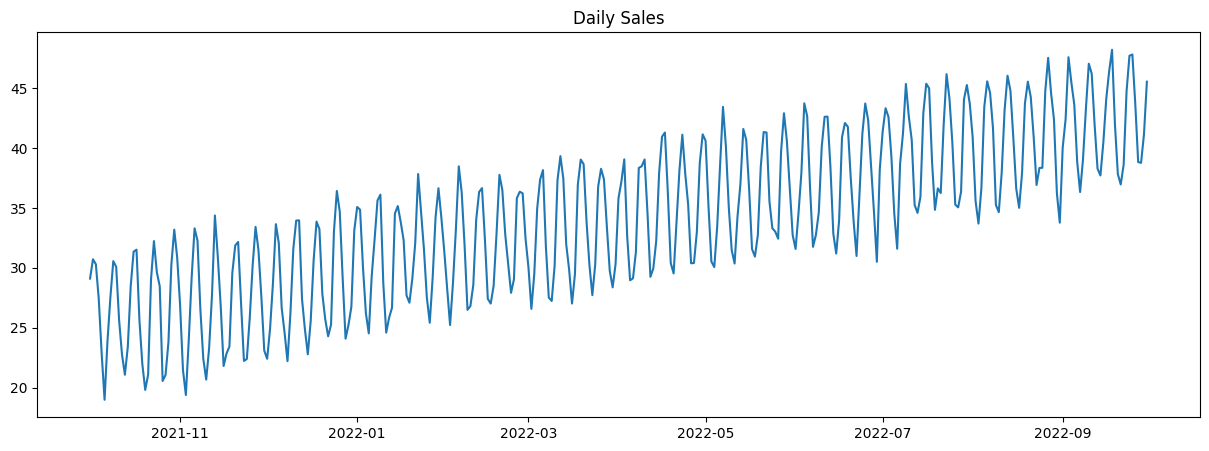

In [10]:
plt.figure(figsize=(15,5))
plt.title('Daily Sales')
plt.plot(df.Date, df.Sales)
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Sales   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


# ADF Test

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(series):
    # Rolling statistics
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Original', color='green')
    plt.plot(rolling_mean, color='red')
    plt.plot(rolling_std, color='black')
    plt.legend(loc='best')
    plt.show()

    # ADF test
    result = adfuller(series, autolag='AIC')
    print(f'Result of Dickey-Fuller Test:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Number of lags: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis of non-stationarity)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

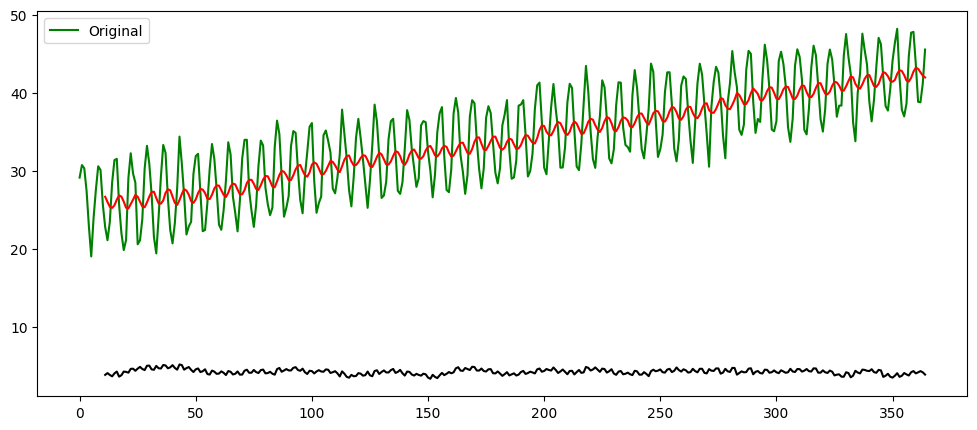

Result of Dickey-Fuller Test:
ADF Statistic: 0.3405
p-value: 0.9791
Number of lags: 16
Number of Observations Used: 348
Critical Values:
   1%: -3.4493
   5%: -2.8699
   10%: -2.5712
Result: Non-stationary (fail to reject null hypothesis)


In [13]:
test_stationarity(df.Sales)

Since p-value(0.991512) is greater than the significance level(0.05), so the data is non-stationary. Now, we have to move forward for differencing the series and see how the autocorrelation plot looks like.

# ACF and PACF Plot

In [14]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def time_series_analysis(series, lags=40, figsize=(12, 5), style='bmh', title=''):
    if not isinstance(series, pd.Series):
            series = pd.Series(series)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        # Plot time series
        series.plot(ax=ts_ax)
        p_value = adfuller(series.dropna())[1]
        ts_ax.set_title(f'Time Series Analysis Plots - {title}\nDickey-Fuller: p={p_value:.5f}')
        
        # ACF
        smt.graphics.plot_acf(series.dropna(), lags=lags, ax=acf_ax)
        
        # PACF
        smt.graphics.plot_pacf(series.dropna(), lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

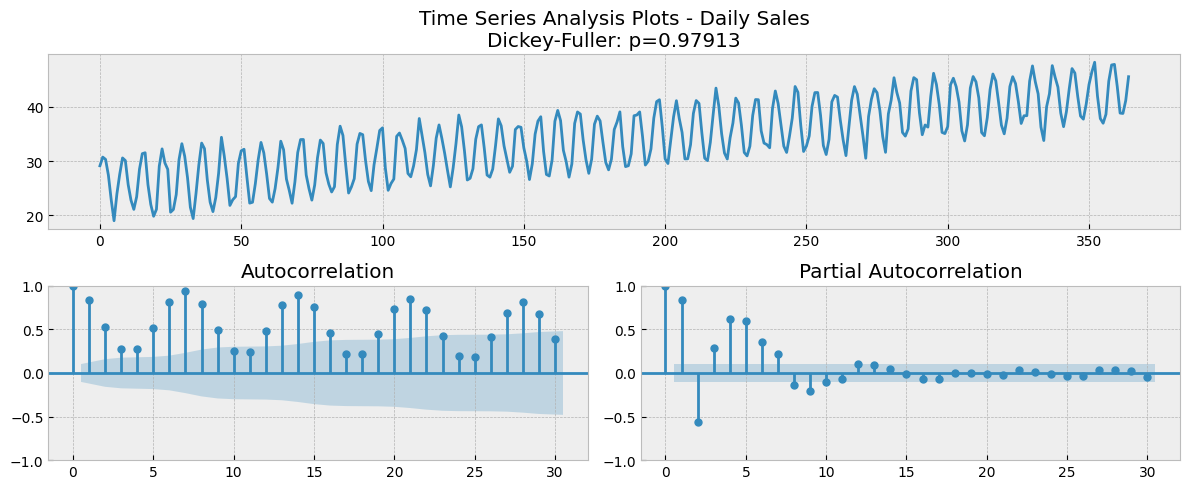

In [15]:
time_series_analysis(df['Sales'], lags=30, title='Daily Sales')


In [16]:
df

,Date,Sales
0,2021-10-01,29.109547
1,2021-10-02,30.720435
2,2021-10-03,30.305173
3,2021-10-04,27.390893
4,2021-10-05,22.841123
...,...,...
360,2022-09-26,43.698457
361,2022-09-27,38.827336
362,2022-09-28,38.761570
363,2022-09-29,41.144471


In [17]:
# 1st order differencing
df_diff = df.diff()
df_diff = df_diff.dropna()

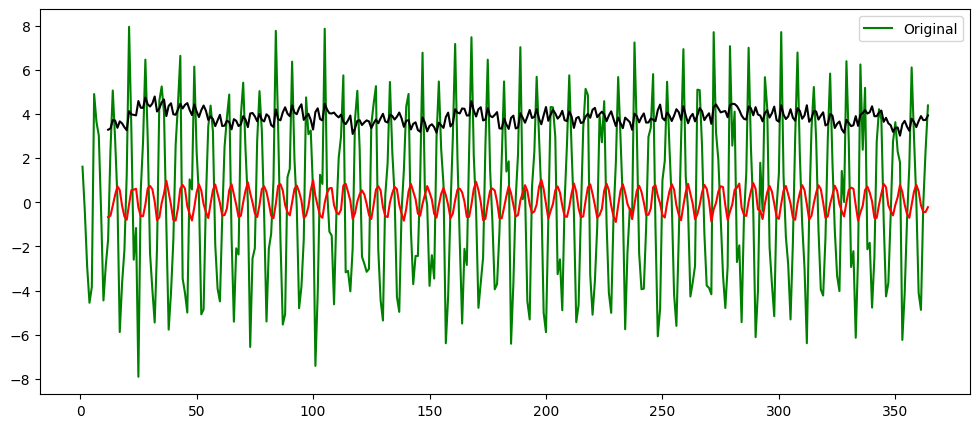

Result of Dickey-Fuller Test:
ADF Statistic: -6.5826
p-value: 0.0000
Number of lags: 17
Number of Observations Used: 346
Critical Values:
   1%: -3.4494
   5%: -2.8699
   10%: -2.5712
Result: Stationary (reject null hypothesis of non-stationarity)


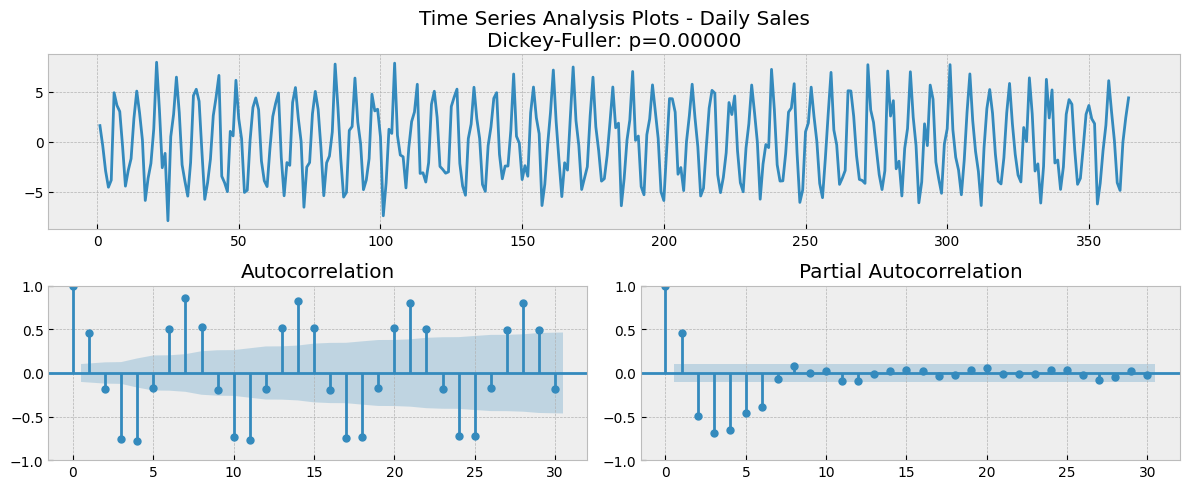

In [18]:
test_stationarity(df_diff['Sales'])
time_series_analysis(df_diff['Sales'], lags=30, title='Daily Sales')


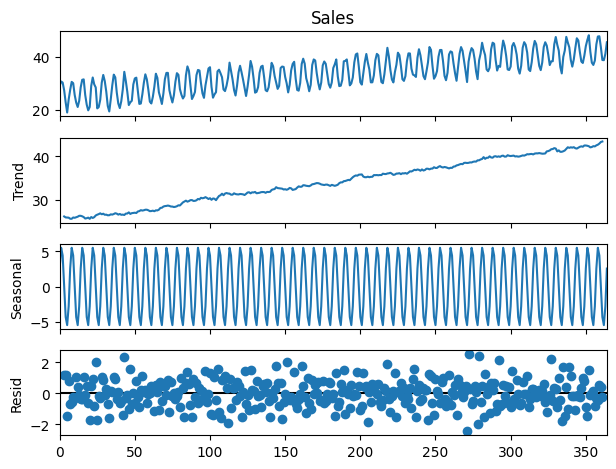

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(df['Sales'], model='additive', period=7)
result.plot()
plt.show()

In [20]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [21]:
stepwise_fit = auto_arima(df['Sales'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1279.752, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1996.649, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1914.496, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1895.318, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1994.702, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1851.808, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1187.397, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1133.913, Time=1.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1166.220, Time=0.93 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1125.975, Time=1.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1144.488, Time=1.07 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1090.269, Time=1.44 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(5, 1, 4)   Log Likelihood                -523.799
Date:                Sun, 17 Aug 2025   AIC                           1069.598
Time:                        09:21:00   BIC                           1112.467
Sample:                             0   HQIC                          1086.637
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0776      0.234      0.332      0.740      -0.380       0.536
ar.L1          0.1696      5.887      0.029      0.977     -11.369      11.708
ar.L2          0.2604      6.570      0.040      0.968     -12.617      13.138
ar.L3         -0.9328      4.647     -0.201      0.841     -10.041       8.175
ar.L4         -0.1322      1.115     -0.119      0.906      -2.317       2.052
ar.L5          0.0401      0.286      0.140      0.888      -0.520       0.600
ma.L1         -1.2001      5.893     -0.204      0.839     -12.750      10.350
ma.L2          0.0274     12.637      0.002      0.998     -24.740      24.795
ma.L3          1.0439     12.090      0.086      0.931     -22.653      24.740
ma.L4         -0.8430      5.262     -0.160      0.873     -11.155       9.469
sigma2         0.9853      0.082     12.014      0.000       0.825       1.146
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.53   Prob(JB):                         0.65
Heteroskedasticity (H):               0.83   Skew:                             0.10
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Split Data into Training and Testing

In [22]:
df

,Date,Sales
0,2021-10-01,29.109547
1,2021-10-02,30.720435
2,2021-10-03,30.305173
3,2021-10-04,27.390893
4,2021-10-05,22.841123
...,...,...
360,2022-09-26,43.698457
361,2022-09-27,38.827336
362,2022-09-28,38.761570
363,2022-09-29,41.144471


In [23]:
print(df.shape)
train = df.iloc[:-80]
test = df.iloc[-80:]
print(train.shape, test.shape)

(365, 2)
(285, 2) (80, 2)


In [24]:
from statsmodels.tsa.arima.model import ARIMA



# Training the ARIMA model

Comparision between Forecast values and Actual Values

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  285
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -426.998
Date:                Sun, 17 Aug 2025   AIC                            873.996
Time:                        09:21:00   BIC                            910.486
Sample:                             0   HQIC                           888.626
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0702      0.225      0.312      0.755      -0.371       0.511
ar.L2          0.0795      0.186      0.428      0.669      -0.285       0.444
ar.L3         -0.8049      0.166     -4.858      0.0

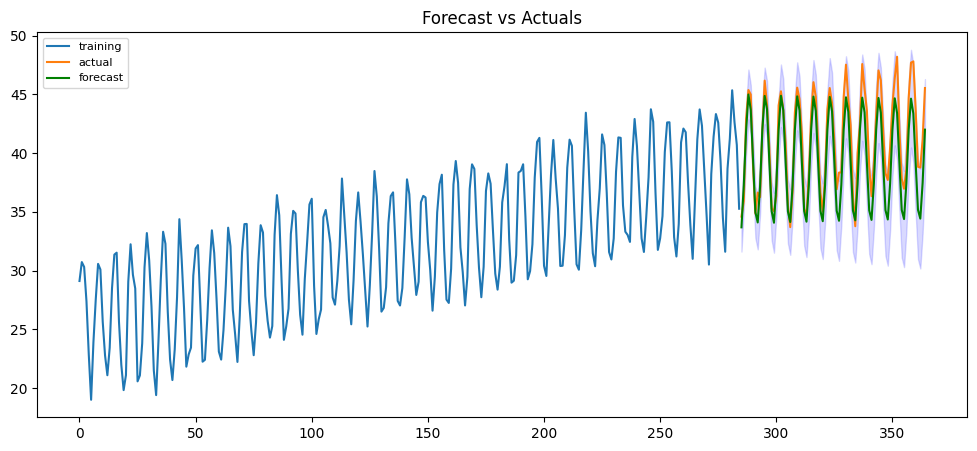

In [25]:
# Build Model
# Build Model
model = ARIMA(train['Sales'], order=(5,1,4))  
fitted = model.fit() 
print(fitted.summary())

# Forecast object
forecast_obj = fitted.get_forecast(steps=len(test))

# Extract forecast mean and confidence intervals
forecast_series = forecast_obj.predicted_mean
conf = forecast_obj.conf_int(alpha=0.05)
lower_series = conf.iloc[:, 0]
upper_series = conf.iloc[:, 1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Sales'], label='training')
plt.plot(test['Sales'], label='actual')
plt.plot(forecast_series, label='forecast', color = 'g')
plt.fill_between(test.index, lower_series, upper_series, color='b', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


<Axes: >

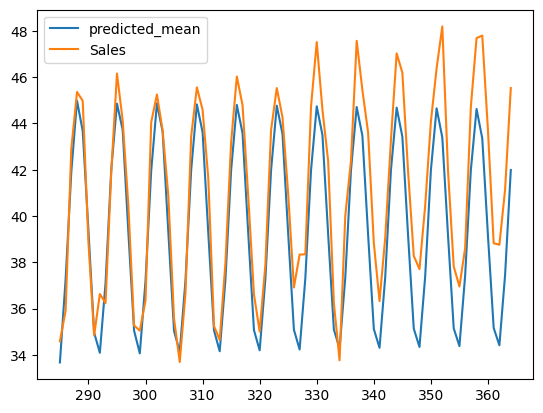

In [26]:
forecast_series.plot(legend = True)
test['Sales'].plot(legend = True)

In [27]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy_df(forecast, actual):
    # Ensure numpy arrays
    forecast = np.array(forecast)
    actual = np.array(actual)

    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100     # MAPE
    me = np.mean(forecast - actual)                                 # ME
    mae = np.mean(np.abs(forecast - actual))                        # MAE
    mpe = np.mean((forecast - actual) / actual)                     # MPE
    rmse = np.sqrt(np.mean((forecast - actual)**2))                 # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]                      # Corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)                               # MinMax
    acf1 = acf(forecast - actual)[1]                                # ACF1

    # Create DataFrame
    metrics_df = pd.DataFrame({
        'MAPE': [mape],
        'ME': [me],
        'MAE': [mae],
        'MPE': [mpe],
        'RMSE': [rmse],
        'ACF1': [acf1],
        'Corr': [corr],
        'MinMax': [minmax]
    })

    return metrics_df

# Example usage
metrics_df = forecast_accuracy_df(forecast_series, test['Sales'])
print(metrics_df)




       MAPE        ME       MAE       MPE      RMSE     ACF1      Corr  \
0  4.345301 -1.672331  1.804599 -0.039783  2.190502  0.48289  0.939206   

     MinMax  
0  0.043412  


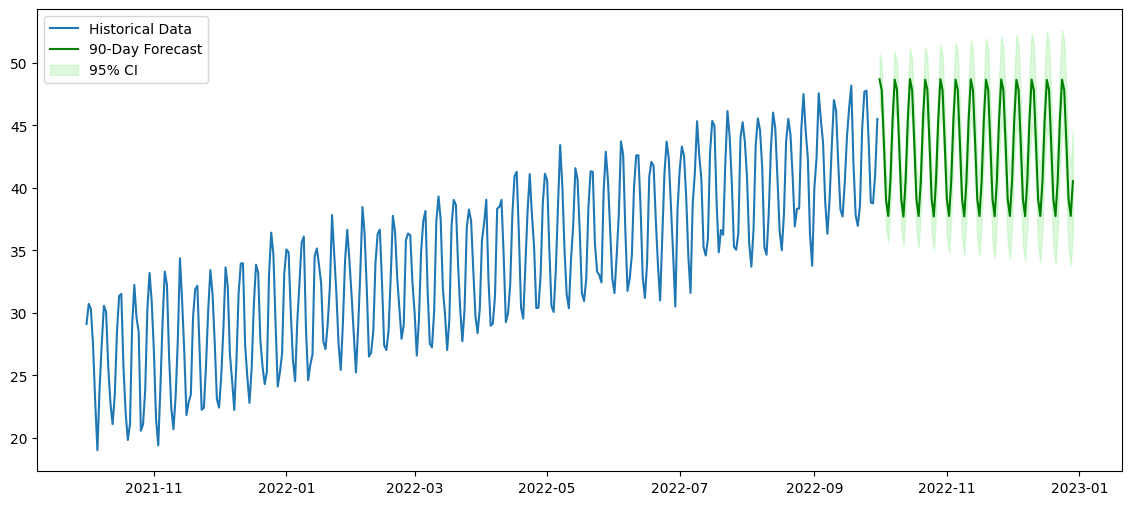

In [28]:
# Fit ARIMA model on entire dataset
fitted_full = ARIMA(df['Sales'], order=(5,1,4)).fit()

# Forecast 90 days ahead
forecast_obj = fitted_full.get_forecast(steps=90)

# Extract forecast mean and confidence intervals
forecast_90 = forecast_obj.predicted_mean
conf_90 = forecast_obj.conf_int(alpha=0.05)

# Create forecast index starting from the next day
forecast_index = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=90, freq='D')
forecast_90.index = forecast_index
conf_90.index = forecast_index

# Plot results
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Sales'], label='Historical Data')
plt.plot(forecast_90, label='90-Day Forecast', color='green')
plt.fill_between(forecast_index, conf_90.iloc[:,0], conf_90.iloc[:,1], color='lightgreen', alpha=0.3, label='95% CI')
plt.legend()
plt.show()

# Optional: save forecast
forecast_df = pd.DataFrame({
    'Forecast': forecast_90,
    'Lower_CI': conf_90.iloc[:,0],
    'Upper_CI': conf_90.iloc[:,1]
})
forecast_df.to_csv('90_day_forecast.csv', index_label='Date')


# SARIMA MODEL

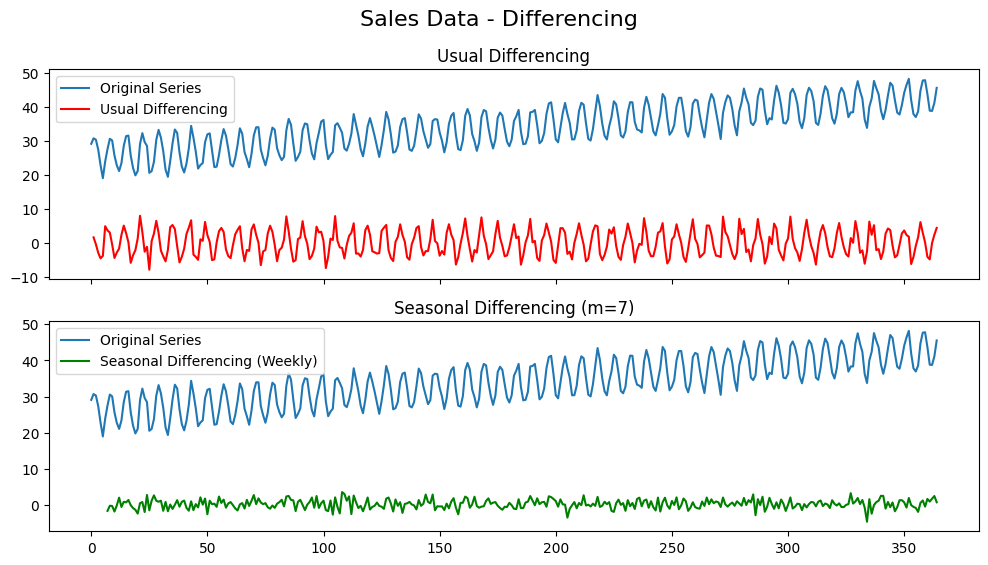

In [29]:
# Plot usual and seasonal differencing
fig, axes = plt.subplots(2, 1, figsize=(12,6), dpi=100, sharex=True)

axes[0].plot(df['Sales'], label='Original Series')
axes[0].plot(df['Sales'].diff(1), label='Usual Differencing', color='red')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

axes[1].plot(df['Sales'], label='Original Series')
axes[1].plot(df['Sales'].diff(7), label='Seasonal Differencing (Weekly)', color='green')
axes[1].set_title('Seasonal Differencing (m=7)')
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle('Sales Data - Differencing', fontsize=16)
plt.show()

In [30]:
import pmdarima as pm

In [31]:
# Fit Seasonal Auto-ARIMA
smodel = pm.auto_arima(
    train['Sales'],
    start_p=1, start_q=1,
    test='adf',
    max_p=5, max_q=5,
    m=7,                  # Weekly seasonality
    start_P=0, seasonal=True,
    d=None, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=923.643, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=860.599, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=940.104, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=924.175, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=848.084, Time=0.38 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=846.628, Time=0.35 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=860.178, Time=0.15 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=848.130, Time=0.59 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=849.958, Time=2.30 sec
 ARIMA

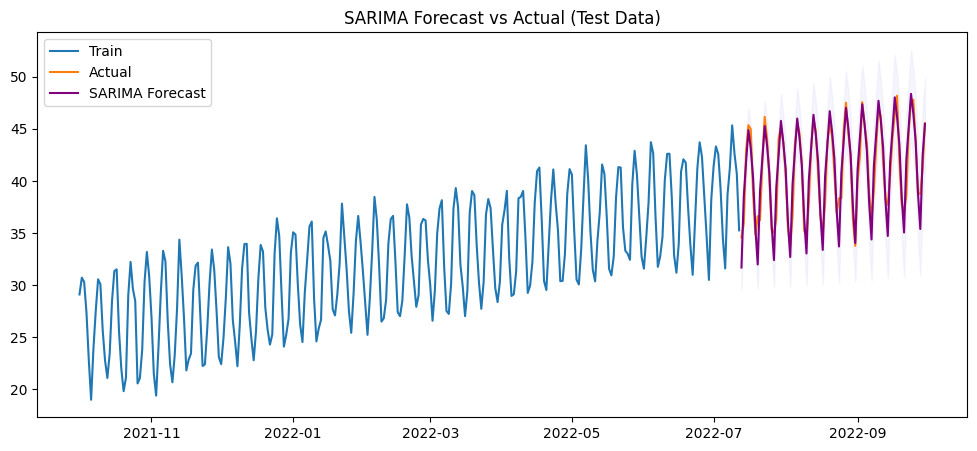

In [32]:
# Forecast on Test Data
n_periods = len(test)
sarima_forecast, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

# Create forecast index for plotting
forecast_index = test['Date']

# Plot SARIMA forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(train['Date'], train['Sales'], label='Train')
plt.plot(test['Date'], test['Sales'], label='Actual')
plt.plot(forecast_index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.fill_between(forecast_index, confint[:,0], confint[:,1], color='lavender', alpha=0.4)
plt.title('SARIMA Forecast vs Actual (Test Data)')
plt.legend()
plt.show()

In [33]:
# Forecast Metrics (using your existing function)
metrics_sarima = forecast_accuracy_df(sarima_forecast, test['Sales'])
print("SARIMA Forecast Metrics:\n", metrics_sarima)


SARIMA Forecast Metrics:
        MAPE        ME       MAE       MPE      RMSE      ACF1      Corr  \
0  3.092665  0.085206  1.211249  0.002105  1.608389 -0.417263  0.930693   

     MinMax  
0  0.030156  


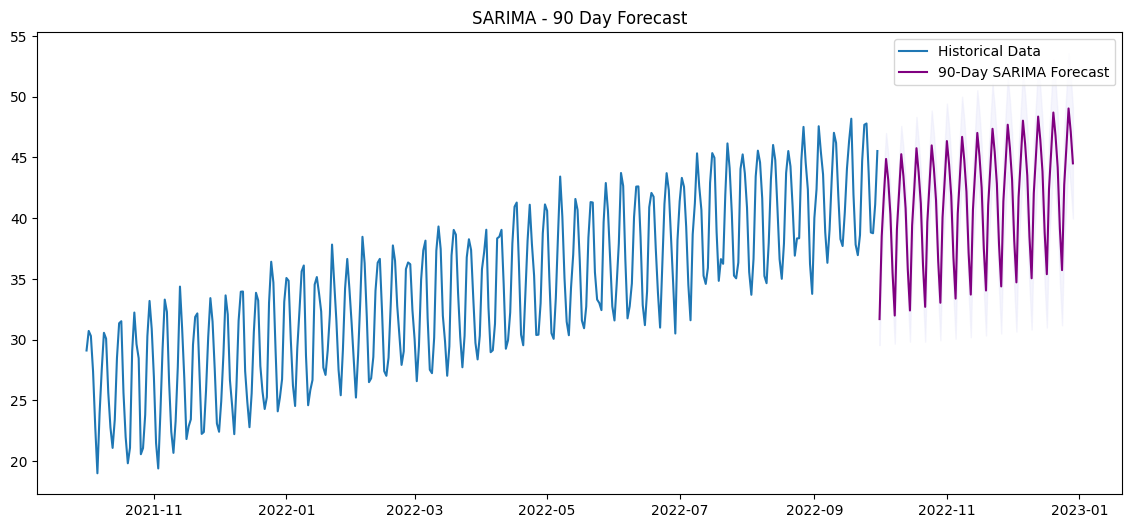

In [34]:
# Forecast 90 Days Ahead from last date
n_future = 90
future_forecast, future_conf = smodel.predict(n_periods=n_future, return_conf_int=True)

# Create future date index
future_index = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future, freq='D')

# Plot 90-day future forecast
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Sales'], label='Historical Data')
plt.plot(future_index, future_forecast, label='90-Day SARIMA Forecast', color='purple')
plt.fill_between(future_index, future_conf[:,0], future_conf[:,1], color='lavender', alpha=0.4)
plt.title('SARIMA - 90 Day Forecast')
plt.legend()
plt.show()

# Exponential Smoothening

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

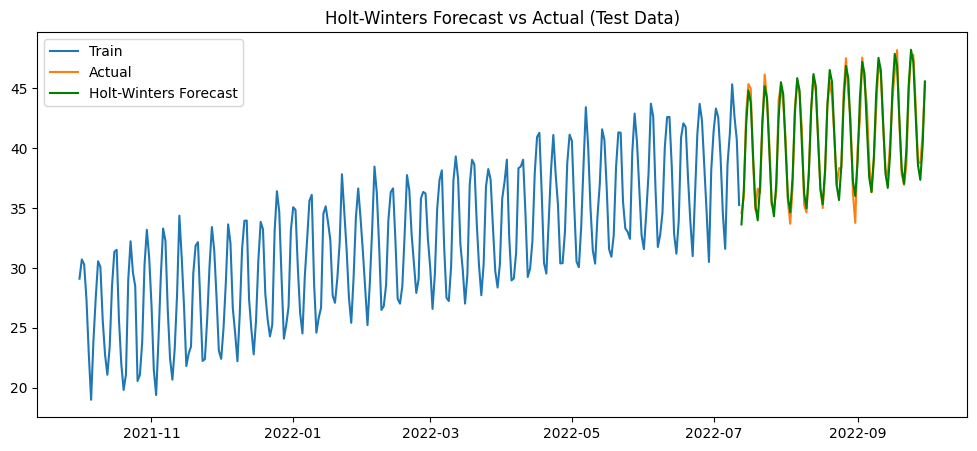

In [36]:
# Fit Holt-Winters Model (Additive trend & seasonality with m=7 for weekly)
hw_model = ExponentialSmoothing(
    train['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

# 4. Forecast on Test Data
hw_forecast = hw_model.forecast(len(test))

# Plot Holt-Winters forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(train['Date'], train['Sales'], label='Train')
plt.plot(test['Date'], test['Sales'], label='Actual')
plt.plot(test['Date'], hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Holt-Winters Forecast vs Actual (Test Data)')
plt.legend()
plt.show()

In [37]:
# Forecast Metrics (using your existing function)
metrics_hw = forecast_accuracy_df(hw_forecast, test['Sales'])
print("Holt-Winters Forecast Metrics:\n", metrics_hw)

Holt-Winters Forecast Metrics:
        MAPE        ME       MAE       MPE      RMSE      ACF1      Corr  \
0  1.796314 -0.046313  0.728511 -0.000923  0.927745 -0.115293  0.974951   

     MinMax  
0  0.017749  


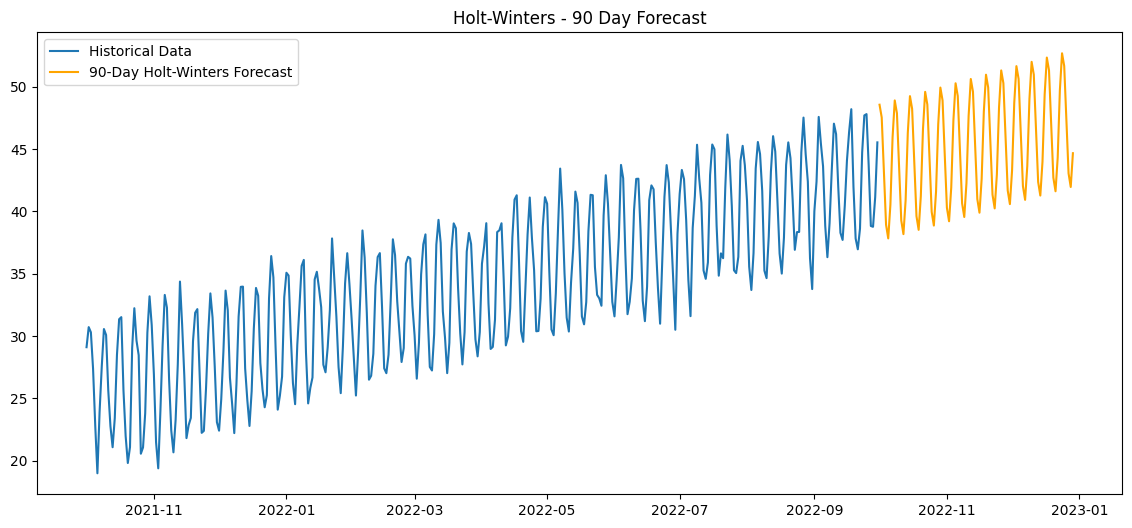

In [38]:
# 6. Forecast 90 Days Ahead from last date
hw_model_full = ExponentialSmoothing(
    df['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

future_hw_forecast = hw_model_full.forecast(90)

# Create future date index
future_index = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=90, freq='D')

# Plot 90-day future forecast
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Sales'], label='Historical Data')
plt.plot(future_index, future_hw_forecast, label='90-Day Holt-Winters Forecast', color='orange')
plt.title('Holt-Winters - 90 Day Forecast')
plt.legend()
plt.show()

**Data Visualisation**

In [39]:
# df.set_index('Date',inplace=True)
# df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [40]:
df.head()

,Sales
Date,
2021-10-01,29.109547
2021-10-02,30.720435
2021-10-03,30.305173
2021-10-04,27.390893
2021-10-05,22.841123


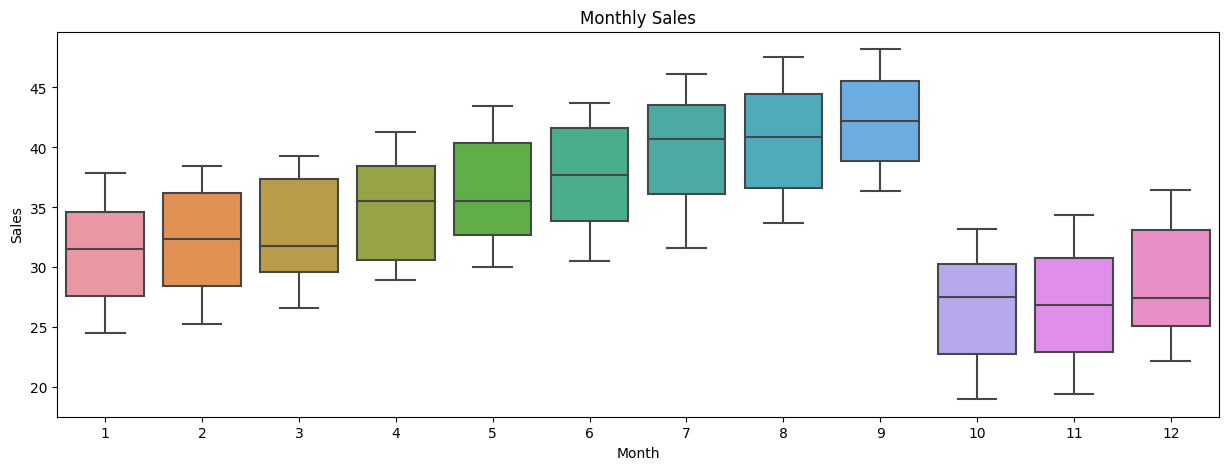

In [41]:
# Create box plots to visualize the monthly variation for Sales
plt.figure(figsize=(15, 5))
sns.boxplot(x=df.index.month, y='Sales', data=df)
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

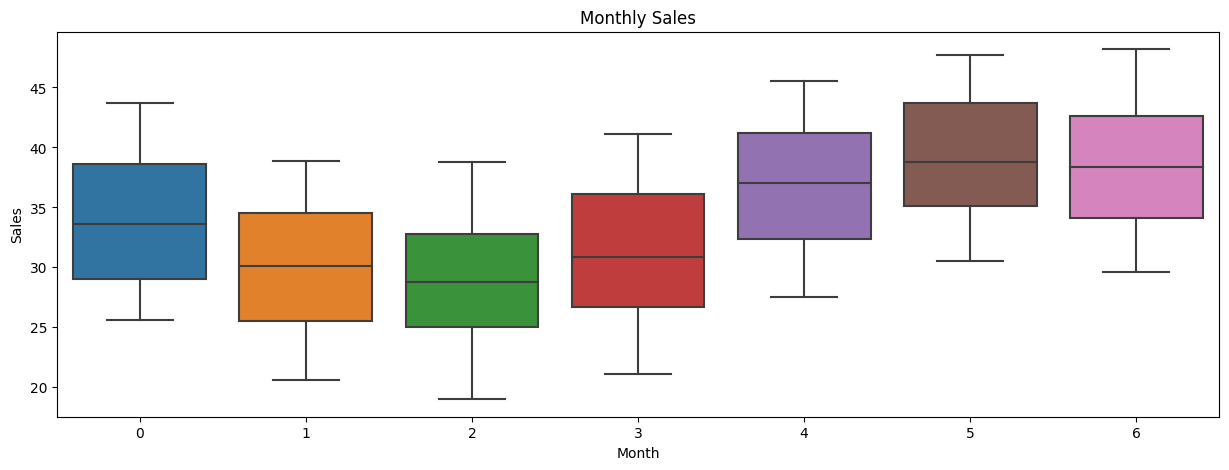

In [42]:
# Create box plots to visualize the day variation for Sales
plt.figure(figsize=(15, 5))
sns.boxplot(x=df.index.dayofweek, y='Sales', data=df)
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()
#There are lots of sales rates are high in the weekends

# Prophet Model

In [76]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [77]:
# Load and preprocess data
df = pd.read_csv("/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv")
df = df[["Date", "Sales"]]
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Split into train and test (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [78]:
# Fit Prophet model with additive seasonality (default)
prophet_model = Prophet(
    yearly_seasonality=False,  # Disable yearly seasonality (data is 1 year)
    weekly_seasonality=True,   # Enable weekly seasonality
    daily_seasonality=True,   # Enable daily seasonality
    seasonality_mode='additive'  # Explicitly set additive mode
)
prophet_model.fit(train)

09:57:02 - cmdstanpy - INFO - Chain [1] start processing
09:57:03 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Define MAPE function
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    # Avoid division by zero
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

Prophet Additive RMSE: 0.9473365559753868
Prophet Additive MAPE: 1.84%


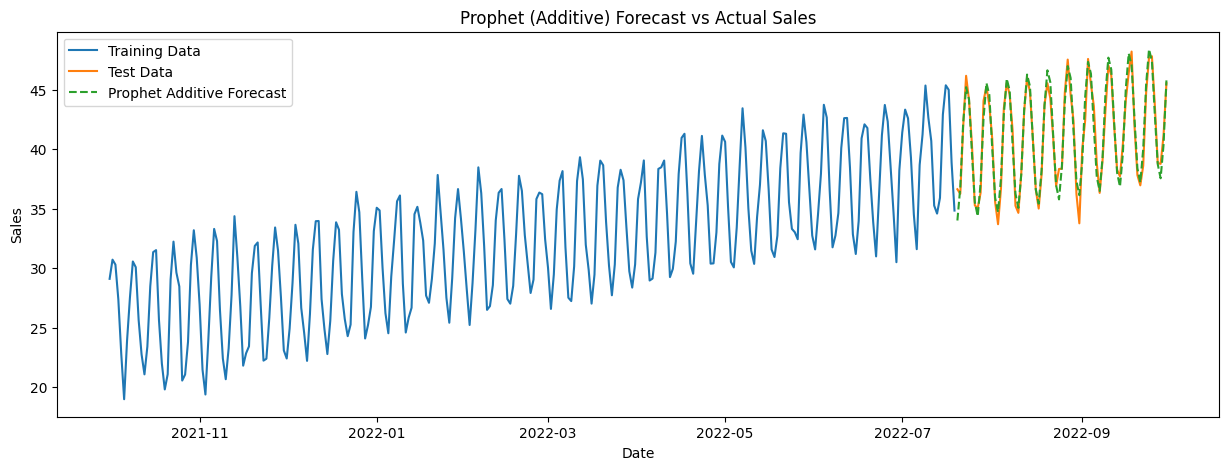

In [81]:



# Create future dataframe for forecasting
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast = prophet_model.predict(future)

# Extract forecast for test period
forecast_test = forecast[forecast['ds'].isin(test['ds'])][['ds', 'yhat']]
forecast_df = pd.DataFrame({'Forecast': forecast_test['yhat'].values}, index=test['ds'])

# Evaluate
rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mape = calculate_mape(test['y'], forecast_test['yhat'])
print(f"Prophet Additive RMSE: {rmse}")
print(f"Prophet Additive MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Prophet Additive Forecast', linestyle='--')
plt.title('Prophet (Additive) Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [83]:
# Fit Prophet model with multiplicative seasonality
prophet_model = Prophet(
    yearly_seasonality=False,  # Disable yearly seasonality (data is 1 year)
    weekly_seasonality=True,   # Enable weekly seasonality
    daily_seasonality=True,   # Enable daily seasonality
    seasonality_mode='multiplicative'  # Set multiplicative mode
)
prophet_model.fit(train)

# Create future dataframe for forecasting
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast = prophet_model.predict(future)


09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet Multiplicative RMSE: 1.5308348008738488
Prophet Additive MAPE: 3.02%


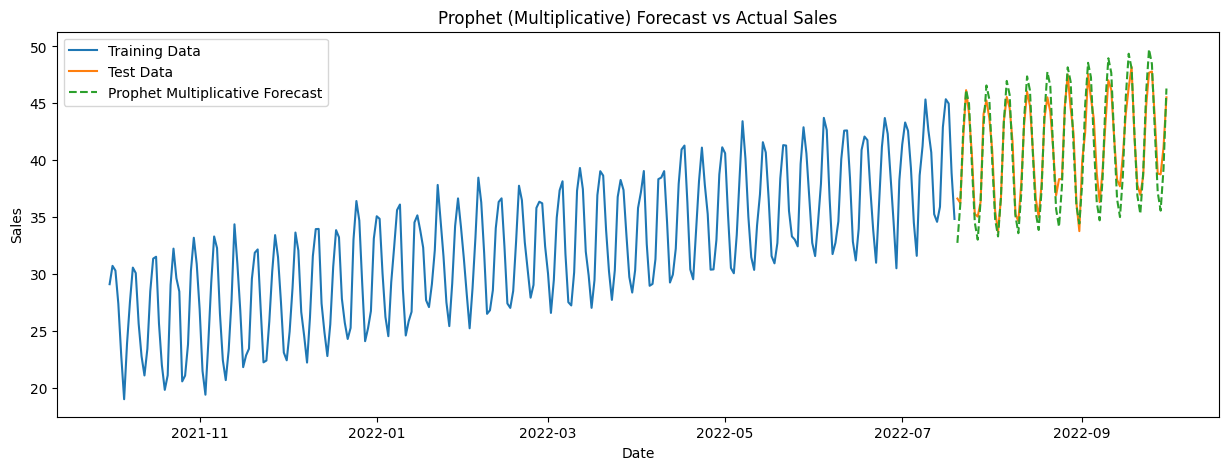

In [84]:
# Extract forecast for test period
forecast_test = forecast[forecast['ds'].isin(test['ds'])][['ds', 'yhat']]
forecast_df = pd.DataFrame({'Forecast': forecast_test['yhat'].values}, index=test['ds'])

# Evaluate
rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mape = calculate_mape(test['y'], forecast_test['yhat'])
print(f"Prophet Multiplicative RMSE: {rmse}")
print(f"Prophet Additive MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Prophet Multiplicative Forecast', linestyle='--')
plt.title('Prophet (Multiplicative) Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# XG Boost Model

In [85]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['day'] = df.index.day
    df['year'] = df.index.year
    return df

# 2. Define create_lag_features function
def create_lag_features(df, lags=[1, 7], target_col='Sales'):

    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Load and preprocess data
df = pd.read_csv("/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv")
df = df[["Date", "Sales"]]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Apply feature creation functions
df = create_features(df)
df = create_lag_features(df, lags=[1, 7])

In [86]:
# Train-Test Split
train = df.loc[df.index < '2022-07-15']
test = df.loc[df.index >= '2022-07-15']

feature_cols = ['dayofweek', 'month', 'quarter', 'day', 'year', 'lag_1', 'lag_7']
target_col = 'Sales'

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

# Train XGBoost with tuned parameters
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [87]:
# Predict on Test Set
test['prediction'] = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, test['prediction'])
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
mape = np.mean(np.abs((y_test - test['prediction']) / y_test)) * 100
r2 = r2_score(y_test, test['prediction'])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")


MAE: 1.77
RMSE: 2.20
MAPE: 4.15%
R²: 0.71


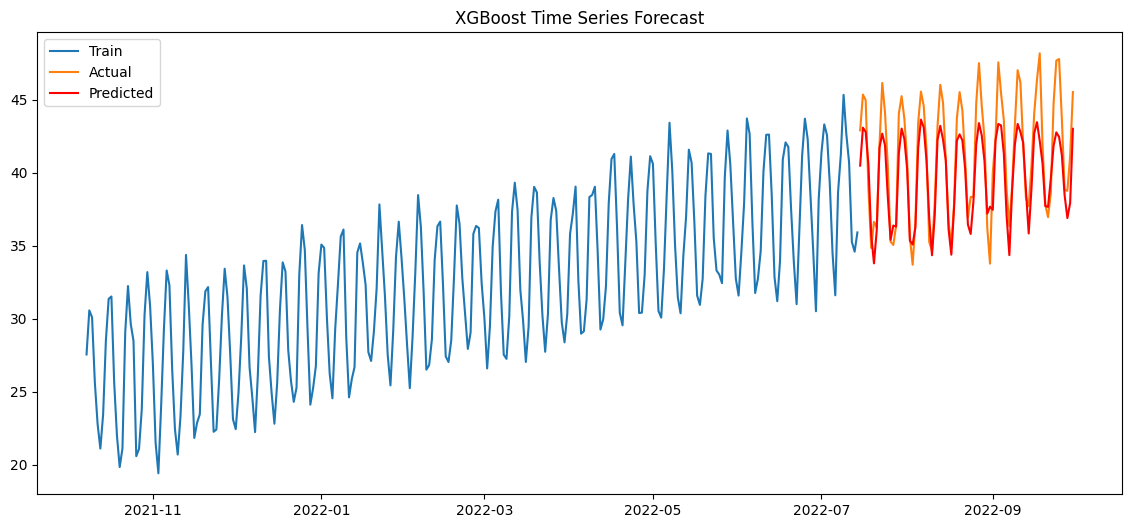

In [88]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Sales'], label="Train")
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, test['prediction'], label="Predicted", color='red')
plt.title("XGBoost Time Series Forecast")
plt.legend()
plt.show()

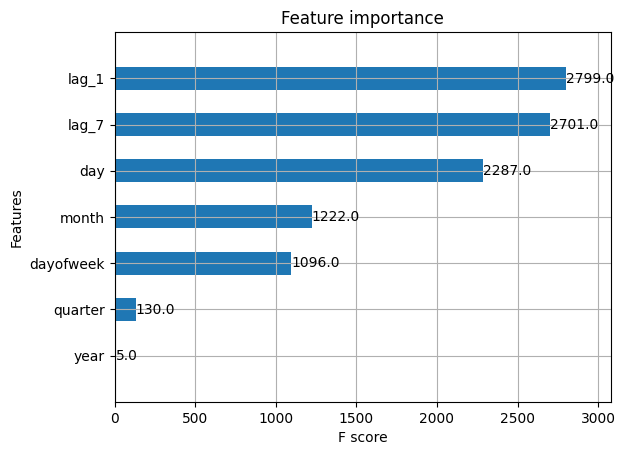

In [89]:
# Feature Importance
xgb.plot_importance(model, height=0.5)
plt.show()

# Forecast Next 90 Days
future_forecast = []
last_values = df[['Sales']].iloc[-7:].values.flatten().tolist()  # last 7 days

for i in range(90):
    future_date = df.index[-1] + pd.Timedelta(days=i+1)
    features = [
        future_date.dayofweek,
        future_date.month,
        future_date.quarter,
        future_date.day,
        future_date.year,
        last_values[-1],   # lag_1
        last_values[-7]    # lag_7
    ]
    pred = model.predict(np.array(features).reshape(1, -1))[0]
    future_forecast.append(pred)
    last_values.append(pred)


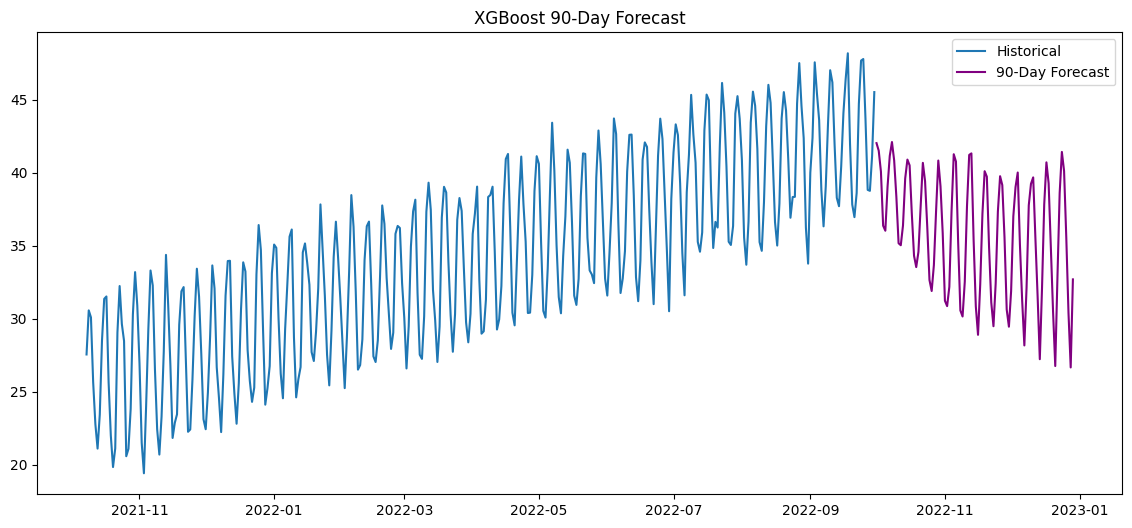

In [90]:
# Plot 90-day forecast
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(future_index, future_forecast, label='90-Day Forecast', color='purple')
plt.title("XGBoost 90-Day Forecast")
plt.legend()
plt.show()

In [91]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [92]:
# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500, 700],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [93]:
# Get best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best Parameters:", best_params)

# Predict on Test Set
test['prediction'] = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, test['prediction'])
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
mape = np.mean(np.abs((y_test - test['prediction']) / y_test)) * 100
r2 = r2_score(y_test, test['prediction'])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
MAE: 1.69
RMSE: 2.10
MAPE: 4.00%
R²: 0.73


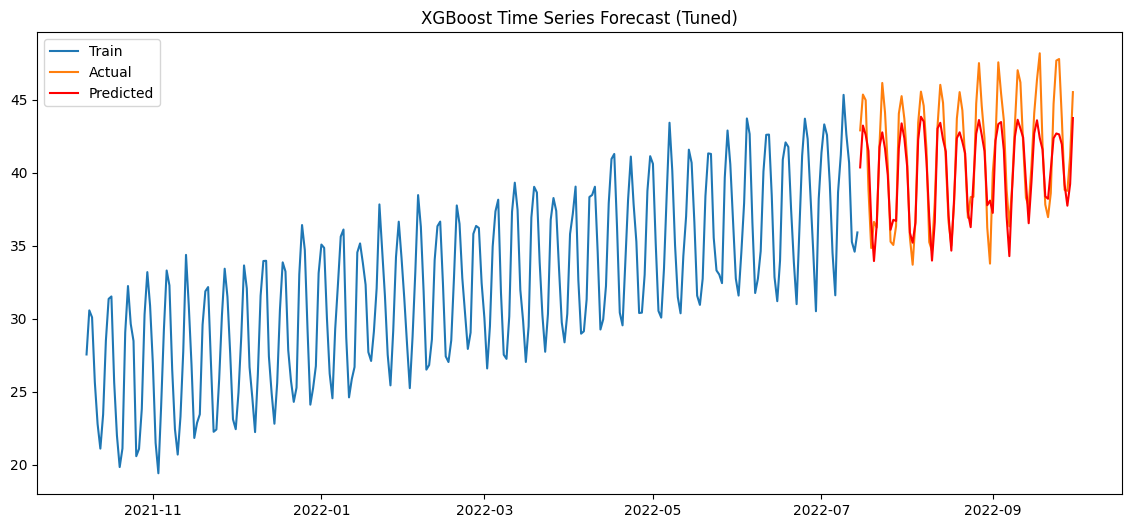

In [94]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Sales'], label="Train")
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, test['prediction'], label="Predicted", color='red')
plt.title("XGBoost Time Series Forecast (Tuned)")
plt.legend()
plt.show()

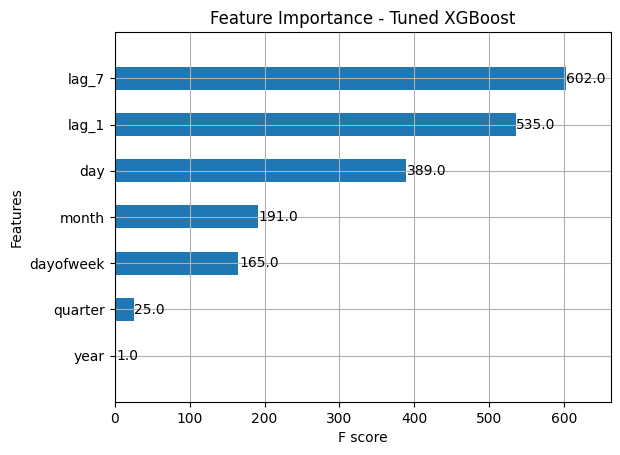

In [95]:
# Feature Importance Plot
xgb.plot_importance(best_model, height=0.5)
plt.title('Feature Importance - Tuned XGBoost')
plt.show()

In [96]:
import pandas as pd

# Convert metrics to dictionary if they are not already
metrics_dict = {
    'ARIMA': {
        'MAE': metrics_df['MAE'].values[0],
        'RMSE': metrics_df['RMSE'].values[0],
        'MAPE': metrics_df['MAPE'].values[0],
        'R²': metrics_df['Corr'].values[0]  # if using correlation as R² substitute
    },
    'SARIMA': {
        'MAE': metrics_sarima['MAE'].values[0],
        'RMSE': metrics_sarima['RMSE'].values[0],
        'MAPE': metrics_sarima['MAPE'].values[0],
        'R²': metrics_sarima['Corr'].values[0]
    },
    'Holt-Winters': {
        'MAE': metrics_hw['MAE'].values[0],
        'RMSE': metrics_hw['RMSE'].values[0],
        'MAPE': metrics_hw['MAPE'].values[0],
        'R²': metrics_hw['Corr'].values[0]
    },
    'XGBoost': {
        'MAE': mae,        # from sklearn metrics
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }
}

# Create a DataFrame for comparison
forecast_errors = pd.DataFrame(metrics_dict).T  # transpose for models as rows
forecast_errors = forecast_errors[['MAE','RMSE','MAPE','R²']]  # reorder columns

# Display
print("Forecast Error Comparison:")
print(forecast_errors)


Forecast Error Comparison:
                   MAE      RMSE      MAPE        R²
ARIMA         1.804599  2.190502  4.345301  0.939206
SARIMA        1.211249  1.608389  3.092665  0.930693
Holt-Winters  0.728511  0.927745  1.796314  0.974951
XGBoost       1.690135  2.098520  3.997483  0.733098
